In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import tensorflow
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout
from keras.layers import Activation
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [50]:
#MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [89]:
df = pd.read_csv('user.csv', index_col=[0], parse_dates=['timestamp'])

In [90]:
df.head()

,usage
timestamp,
2017-01-19 10:00:00.263,8578
2017-01-20 00:00:05.300,8698
2017-01-21 00:00:00.273,8147
2017-01-22 00:00:02.480,8359
2017-01-23 00:00:00.263,7484


In [91]:
df.describe()

,usage
count,1165.000000
mean,8694.447210
std,2150.758828
min,624.000000
25%,7774.000000
50%,8706.000000
75%,9728.000000
max,62272.000000


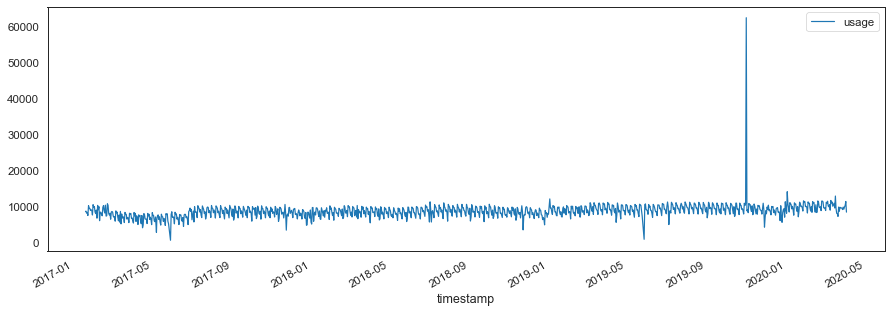

In [92]:
_ = df[['usage']].plot(figsize=(15, 5))

# There is an anomaly on the data
so lets change it with the mean of the data

In [93]:
mymap = {62272:8694.44}
df=df.applymap(lambda s: mymap.get(s) if s in mymap else s)

In [94]:
df.describe()

,usage
count,1165.000000
mean,8648.457888
std,1468.854955
min,624.000000
25%,7774.000000
50%,8703.000000
75%,9725.000000
max,14079.000000


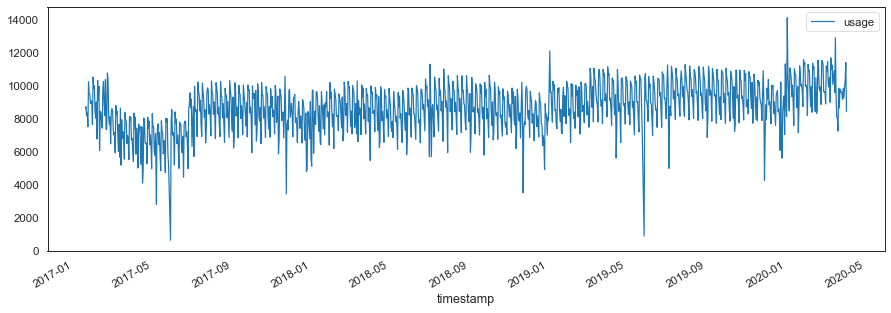

In [95]:
_ = df[['usage']].plot(figsize=(15, 5))

Looks pretty good

In [96]:
split_date = '01-Jan-2020'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

In [97]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

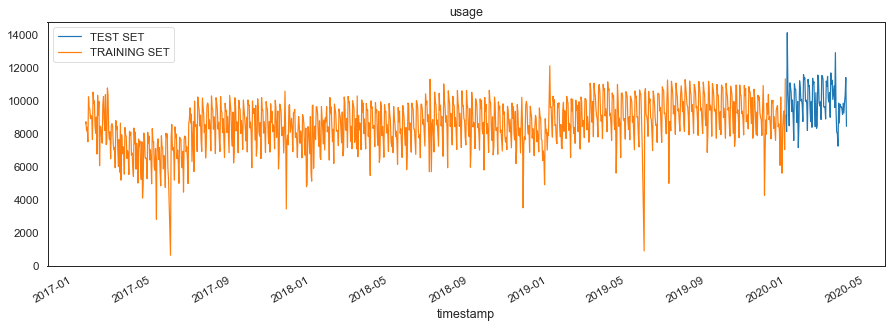

In [98]:
_ = data_test \
    .rename(columns={'usage': 'TEST SET'}) \
    .join(data_train.rename(columns={'usage': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='usage', style='-')

In [99]:
#LSTM Model
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [100]:
model.fit(X_train, y_train, epochs=100, batch_size=7, verbose=2)

Train on 1070 samples
Epoch 1/100
1070/1070 - 3s - loss: 0.0506
Epoch 2/100
1070/1070 - 1s - loss: 0.0153
Epoch 3/100
1070/1070 - 1s - loss: 0.0153
Epoch 4/100
1070/1070 - 1s - loss: 0.0154
Epoch 5/100
1070/1070 - 1s - loss: 0.0152
Epoch 6/100
1070/1070 - 1s - loss: 0.0151
Epoch 7/100
1070/1070 - 1s - loss: 0.0149
Epoch 8/100
1070/1070 - 1s - loss: 0.0153
Epoch 9/100
1070/1070 - 1s - loss: 0.0150
Epoch 10/100
1070/1070 - 1s - loss: 0.0147
Epoch 11/100
1070/1070 - 2s - loss: 0.0149
Epoch 12/100
1070/1070 - 1s - loss: 0.0152
Epoch 13/100
1070/1070 - 2s - loss: 0.0153
Epoch 14/100
1070/1070 - 2s - loss: 0.0156
Epoch 15/100
1070/1070 - 1s - loss: 0.0149
Epoch 16/100
1070/1070 - 2s - loss: 0.0151
Epoch 17/100
1070/1070 - 2s - loss: 0.0148
Epoch 18/100
1070/1070 - 2s - loss: 0.0151
Epoch 19/100
1070/1070 - 1s - loss: 0.0143
Epoch 20/100
1070/1070 - 1s - loss: 0.0148
Epoch 21/100
1070/1070 - 1s - loss: 0.0146
Epoch 22/100
1070/1070 - 1s - loss: 0.0148
Epoch 23/100
1070/1070 - 1s - loss: 0.014

In [101]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [102]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_dau = model.predict(inputs)
predicted_dau = sc.inverse_transform(predicted_dau)

In [103]:
data_test['Prediction'] = predicted_dau
data_all = pd.concat([data_test, data_train], sort=False)

In [104]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Prediction': 'lstm'})
final_data = final_data[['timestamp','usage','lstm']]

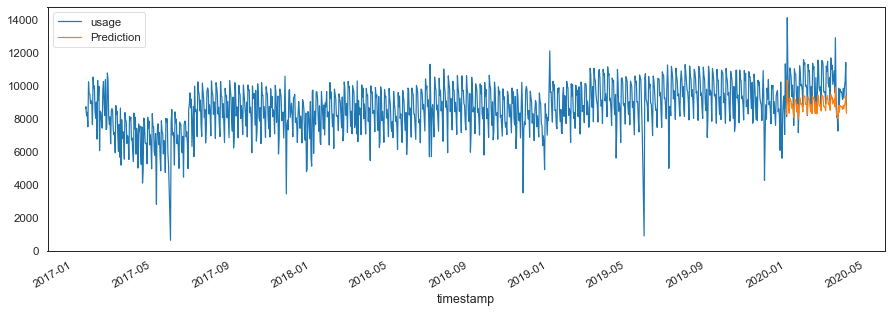

In [105]:
_ = data_all[['usage','Prediction']].plot(figsize=(15, 5))

As we look at the graph, the prediction that colored yellow is not that fit with the test set, it pretty much lower than the actual data, perhaps because the data have some outliers of small data. but we cannot change them since it is a timeseries data which mean every past value is meaningful to the future. What we can do is make the model more robust to the outliers

In [106]:
mean_absolute_percentage_error(y_true=data_test['usage'],
                   y_pred=data_test['Prediction'])

11.127028792989922

In [107]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
